In [1]:
##################
#####################

# import basic modules
import os, sys
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sn
from tensorflow.python.platform.tf_logging import warn
from preprocessing_functions import from_2_to_3_dimensions
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
import keras

###--- utils functions ---###
# function to plot a complete confusion matrix with common metrics.
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                          path=None):
    '''
    ###############################################################################################
    CITATION: taken from: https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
    ###############################################################################################
    
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sn.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    
    if path:
        plt.tight_layout()
        plt.savefig(path)

In [2]:
###--- define inputs ---###
# features extraction folder path
features_filepath = "/lustre/bio_running/A_to_I_Pietro/model_test_2023/src/kidney_dataset/kidney_extracted_pos_neg_sites_rediportal_13112023.feature_vectors.tsv"
# file with metadata
metadata_filepath = "/lustre/bio_running/A_to_I_Pietro/model_test_2023/src/kidney_dataset/kidney_extracted_pos_neg_sites_rediportal_13112023.feature_vectors.metadata.tsv"

###-- define outputs ---###
model_path = "/lustre/bio_running/A_to_I_Pietro/model_test_2023/src/kidney_dataset/cnn_wavenet_14112023"
if not os.path.exists(model_path):
    os.mkdir(model_path)

# define model name
model_name = f'model_WaveNet_small_log_preprocessing{datetime.now().strftime("%d_%m_%Y_%H_%M_%S")}.h5'

In [3]:
###--- START LOADING OF DATA ---###
X = pd.read_table(features_filepath, header=None)
y = pd.read_table(metadata_filepath)
# trasform into 3d tensor from series of 2d table from tsv input file
X_3d = from_2_to_3_dimensions(X, 8)
X_3d.shape

(58219, 101, 8)

In [4]:
# do some checks on the first editing
print(y.iloc[0])
print()
print(np.unique(X.loc[:7,].values.T == X_3d[0], return_counts=True))

Region                    chr1
Position                880977
Strand                       2
AGrna                 0.010676
AGwgs                      0.0
Type                   Editing
SRR                 SRR1432650
Start                 880927.0
Stop                  881027.0
DeltaStartStop           101.0
TabixIntervalLen           101
Name: 0, dtype: object

(array([ True]), array([808]))


In [5]:
# do some checks on the first SNPs example
snps_example = y.query("Type == 'SNP'").sample(1)
print(snps_example)
pd.DataFrame(X_3d[snps_example.index[0]].T).iloc[:,50]

      Region  Position  Strand     AGrna  AGwgs Type         SRR       Start  \
42113  chr19  18499780       2  0.997976    1.0  SNP  SRR1340662  18499730.0   

             Stop  DeltaStartStop  TabixIntervalLen  
42113  18499830.0           101.0               101  


0    1.000000
1    0.000000
2    0.000000
3    0.000000
4    0.002024
5    0.000000
6    0.997976
7    0.000000
Name: 50, dtype: float64

In [6]:
# print some information
print("X shape:", X_3d.shape, flush=True)
print("y shape:", y.shape, flush=True)

# delete to spare memory
del(X)

print("\nWhole dataset classes count:", np.unique(y.iloc[:,5], return_counts=True), flush=True)

X shape: (58219, 101, 8)
y shape: (58219, 11)

Whole dataset classes count: (array(['Editing', 'SNP'], dtype=object), array([43898, 14321]))


In [7]:
# create a log2 version on pseudo count to zoom differences among edited and non edited sites
# create a tuple containing min and max log2 expected values useful to normalize frequency features
log_range = (-13.28771238, 0.000144262)
# print statistics before log2 normalization and preprocessing
print(pd.Series(((X_3d[:,:,4:]-log_range[0]) / (log_range[1]-log_range[0])).ravel()).describe())
# go to pseudofrequency
X_3d_log2 = X_3d.copy()
X_3d_log2[:,:,4:] = np.log2(X_3d_log2[:,:,4:]+0.0001)
X_3d_log2

count    2.352048e+07
mean     1.018803e+00
std      3.245086e-02
min      9.999891e-01
25%      9.999891e-01
50%      9.999891e-01
75%      1.037272e+00
max      1.075246e+00
dtype: float64


array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -8.34463945e+00, -8.34463945e+00, -8.46800421e-03],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         -4.06756720e-03, -1.32877124e+01, -8.37341006e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.32877124e+01, -1.32877124e+01, -4.30119751e-03],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         -1.32877124e+01,  1.44262291e-04, -1.32877124e+01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.32877124e+01, -1.32877124e+01,  1.44262291e-04],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
          1.44262291e-04, -1.32877124e+01, -1.32877124e+01]],

       [[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
          1.44262291e-04, -1.32877124e+01, -1.32877124e+01],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
          1.44262291e-04, -1.32877124e

In [8]:
# normalize log2 preudo-frequencies using log2 boudaries
X_3d_log2[:,:,4:] = (X_3d_log2[:,:,4:]-log_range[0]) / (log_range[1] - log_range[0])
X_3d_log2

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.71999267e-01, 3.71999267e-01, 9.99351869e-01],
        [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
         9.99683032e-01, 3.39070181e-11, 3.69834086e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.39070181e-11, 3.39070181e-11, 9.99665449e-01],
        ...,
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
         3.39070181e-11, 1.00000000e+00, 3.39070181e-11],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.39070181e-11, 3.39070181e-11, 1.00000000e+00],
        [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
         1.00000000e+00, 3.39070181e-11, 3.39070181e-11]],

       [[0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
         1.00000000e+00, 3.39070181e-11, 3.39070181e-11],
        [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
         1.00000000e+00, 3.39070181e-11, 3.39070181e-11],
        [0.00000000e+00, 

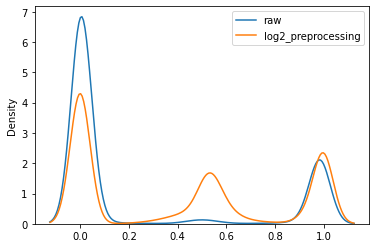

In [11]:
sn.kdeplot(pd.Series(X_3d[:,50,4:].ravel()).sample(100000), label="raw")
sn.kdeplot(pd.Series(X_3d_log2[:,50,4:].ravel()).sample(100000), label="log2_preprocessing")
plt.legend()
plt.show()

In [13]:
del(X_3d)
X_3d_log2.shape

(58219, 101, 8)

In [14]:
# splitting into train, validation and test sets
# produce test set
X_train, X_test, y_train, y_test = train_test_split(X_3d_log2, y, random_state=42, shuffle=True, test_size=0.2)
# produce train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# print some information
print("X train shape:", X_train.shape, flush=True)
print("y_train shape:", y_train.shape, flush=True)
print("X val shape:", X_val.shape, flush=True)
print("y_val shape:", y_val.shape, flush=True)
print("X_test shape", X_test.shape, flush=True)
print("y test shape:", y_test.shape, flush=True)

X train shape: (37260, 101, 8)
y_train shape: (37260, 11)
X val shape: (9315, 101, 8)
y_val shape: (9315, 11)
X_test shape (11644, 101, 8)
y test shape: (11644, 11)


In [20]:
print("\nWhole dataset classes count:", np.unique(y.iloc[:,5], return_counts=True), flush=True)
print("\nTrain dataset classes count:", np.unique(y_train.iloc[:,5], return_counts=True), flush=True)
print("Validation dataset classes count:", np.unique(y_val.iloc[:,5], return_counts=True), flush=True)
print("Test dataset classes count:", np.unique(y_test.iloc[:,5], return_counts=True), flush=True)

print("\nWhole dataset contig count:", np.unique(y.iloc[:,0], return_counts=True), flush=True)
print("\nTrain dataset contig count:", np.unique(y_train.iloc[:,0], return_counts=True), flush=True)
print("Validation dataset contig count:", np.unique(y_val.iloc[:,0], return_counts=True), flush=True)
print("Test dataset contig count:", np.unique(y_test.iloc[:,0], return_counts=True), flush=True)


Whole dataset classes count: (array(['Editing', 'SNP'], dtype=object), array([43898, 14321]))

Train dataset classes count: (array(['Editing', 'SNP'], dtype=object), array([28156,  9104]))
Validation dataset classes count: (array(['Editing', 'SNP'], dtype=object), array([7036, 2279]))
Test dataset classes count: (array(['Editing', 'SNP'], dtype=object), array([8706, 2938]))

Whole dataset contig count: (array(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21',
       'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9',
       'chrX', 'chrY'], dtype=object), array([5871, 1939, 3412, 3350,  788, 2796, 1545, 2882, 4497,  546, 3777,
       4931, 1876,  839, 2549, 2532, 1363, 2445, 2387, 2703, 1634, 2315,
       1196,   46]))

Train dataset contig count: (array(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21',
       '

In [27]:
# encoding y labels to train and test the neural network
print("\nClass 1 is Editing, Class 0 is No-Editing.\n")

### cambiare la funzione to categorical
y_train_le = tf.keras.utils.to_categorical([1 if (i=="Editing") else 0 for i in y_train.iloc[:,5].values])
y_val_le = tf.keras.utils.to_categorical([1 if (i=="Editing") else 0 for i in y_val.iloc[:,5].values])
y_test_le = tf.keras.utils.to_categorical([1 if (i=="Editing") else 0 for i in y_test.iloc[:,5].values])

print()
print("y_train before OHE:\n", y_train)
print("y_train after OHE\n", y_train_le)
print()
print("\ny_val before OHE:\n", y_val)
print("y_val after OHE:\n", y_val_le)
print()
print("\ny_test before OHE:\n", y_test)
print("y_test after OHE:\n", y_test_le)


Class 1 is Editing, Class 0 is No-Editing.


y_train before OHE:
       Region   Position  Strand     AGrna  AGwgs     Type         SRR  \
44519   chr7  148700864       2  0.014184    0.0  Editing  SRR1468426   
35815   chr6   31654960       2  0.011905    0.0  Editing  SRR1447631   
26445  chr11   33886294       2  0.987952    1.0      SNP   SRR810007   
53350  chr11   26690902       2  1.000000    1.0      SNP  SRR1490658   
14380  chr21   45743647       2  0.013333    0.0  Editing  SRR1465871   
...      ...        ...     ...       ...    ...      ...         ...   
18880  chr20   36611707       2  0.016667    0.0  Editing  SRR1469746   
56482  chr12   48175604       2  1.000000    1.0      SNP  SRR1420649   
36738  chr22   22675415       2  0.022222    0.0  Editing  SRR1447631   
36828   chr1   16382602       2  1.000000    1.0      SNP  SRR1447631   
20231   chr6   45866802       2  0.033372    0.0  Editing  SRR1380931   

             Start         Stop  DeltaStartStop  TabixIn

In [33]:
print(pd.DataFrame(y_train_le).value_counts())
print(y_train["Type"].value_counts())

0    1  
0.0  1.0    28156
1.0  0.0     9104
dtype: int64
Editing    28156
SNP         9104
Name: Type, dtype: int64


In [50]:
# define model hyperparameters #################################################################################################################################
n_epoch = 1000
batch_size = 128
optimizer=tf.keras.optimizers.Adam(learning_rate=0.1)
loss="categorical_crossentropy"
n_filters=35
kernel_size=2
dropout=0.2
patience = 150
train_metric = "accuracy"
val_metric = "val_accuracy"

In [51]:
###--- START TRAINING THE MODEL ---###
# retrieve number of classes
n_classes = np.unique(y_train_le).shape[0]

# WaveNet 1dCNN classifier with causal dilation for two classes
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[X_train.shape[1], X_train.shape[2]]))
for rate in (1, 2, 4, 8, 16, 32, 64, 128, 256, 512) * 1:
    model.add(keras.layers.Conv1D(filters=n_filters, kernel_size=kernel_size, activation="relu", 
                                  padding="causal", dilation_rate=rate))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Conv1D(filters=100, kernel_size=2))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(10, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(dropout))
model.add(keras.layers.Dense(n_classes, activation='softmax'))
model.compile(loss=loss, optimizer=optimizer, metrics=[train_metric])
# print model summary
print()
print(model.summary(), flush=True)

# setting callbacks
single_model_path = os.path.join(model_path, model_name)

my_callbacks = [keras.callbacks.EarlyStopping(patience=patience,  monitor=val_metric),
                keras.callbacks.ModelCheckpoint(single_model_path,
                monitor=val_metric, verbose=1, 
                save_best_only=True, mode='max')]


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_99 (Conv1D)          (None, 101, 35)           595       
                                                                 
 conv1d_100 (Conv1D)         (None, 101, 35)           2485      
                                                                 
 conv1d_101 (Conv1D)         (None, 101, 35)           2485      
                                                                 
 conv1d_102 (Conv1D)         (None, 101, 35)           2485      
                                                                 
 conv1d_103 (Conv1D)         (None, 101, 35)           2485      
                                                                 
 conv1d_104 (Conv1D)         (None, 101, 35)           2485      
                                                                 
 conv1d_105 (Conv1D)         (None, 101, 35)         

In [52]:
# train the model
history = model.fit(X_train, y_train_le, epochs=n_epoch, batch_size=batch_size, verbose=1, callbacks=my_callbacks,
                   validation_data=(X_val, y_val_le))

Epoch 1/1000
289/292 [============================>.] - ETA: 0s - loss: 0.2510 - accuracy: 0.9002
Epoch 00001: val_accuracy improved from -inf to 0.75534, saving model to /lustre/bio_running/A_to_I_Pietro/model_test_2023/src/kidney_dataset/cnn_wavenet_14112023/model_WaveNet_small_log_preprocessing14_11_2023_15_01_48.h5
292/292 [==============================] - 7s 18ms/step - loss: 0.2504 - accuracy: 0.9006 - val_loss: 147.8347 - val_accuracy: 0.7553
Epoch 2/1000
291/292 [============================>.] - ETA: 0s - loss: 0.0599 - accuracy: 0.9799
Epoch 00002: val_accuracy improved from 0.75534 to 0.80021, saving model to /lustre/bio_running/A_to_I_Pietro/model_test_2023/src/kidney_dataset/cnn_wavenet_14112023/model_WaveNet_small_log_preprocessing14_11_2023_15_01_48.h5
292/292 [==============================] - 5s 18ms/step - loss: 0.0599 - accuracy: 0.9799 - val_loss: 0.9480 - val_accuracy: 0.8002
Epoch 3/1000
290/292 [============================>.] - ETA: 0s - loss: 0.0167 - accuracy

In [53]:
# save the last model
model.save("/lustre/bio_running/A_to_I_Pietro/model_test_2023/src/kidney_dataset/cnn_wavenet_14112023/model_WaveNet_small_14_11_2023_FINAL.h5")

In [55]:
# load the best model
print(single_model_path)
model = tf.keras.models.load_model(single_model_path)

/lustre/bio_running/A_to_I_Pietro/model_test_2023/src/kidney_dataset/cnn_wavenet_14112023/model_WaveNet_small_log_preprocessing14_11_2023_15_01_48.h5


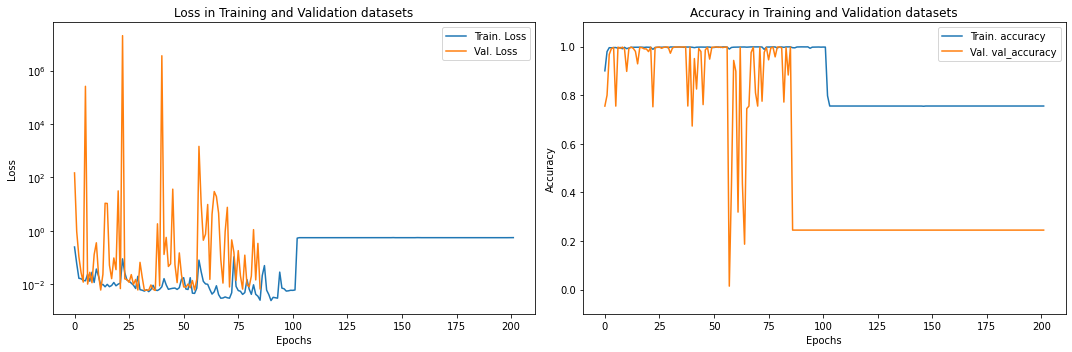

In [56]:
# plot history
f, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(history.history["loss"], label="Train. Loss")
ax[0].plot(history.history["val_loss"], label="Val. Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss in Training and Validation datasets")
ax[0].set_yscale("log")
ax[0].legend()
ax[1].plot(history.history[train_metric], label=f"Train. {train_metric}")
ax[1].plot(history.history[val_metric], label=f"Val. {val_metric}")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_ylim(-0.1 ,1.1)
ax[1].set_title("Accuracy in Training and Validation datasets")
ax[1].legend()
plt.tight_layout()
plt.savefig(os.path.join(model_path, f"{model_name}_Loss_Accuracy.tiff"))
plt.show()


X_train predicted classes count: (array([0, 1]), array([ 9116, 28144]))

Accuracy on training set is: 0.9993558776167472

Confusion Matrix on training set:
 [[ 9098     6]
 [   18 28138]]

Classification Report on training set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9104
           1       1.00      1.00      1.00     28156

    accuracy                           1.00     37260
   macro avg       1.00      1.00      1.00     37260
weighted avg       1.00      1.00      1.00     37260



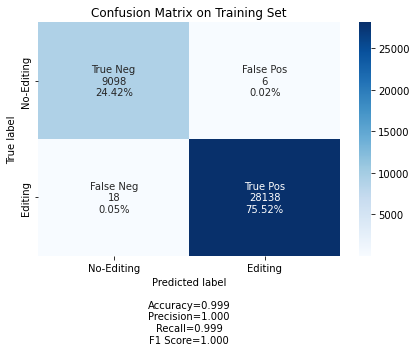

In [57]:
labels = ["True Neg", "False Pos", "False Neg", "True Pos"]
categories = ["No-Editing", "Editing"]

# predict classes on training set and evaluate model perfomances
y_train_hat = model.predict(X_train)
print("\nX_train predicted classes count:", np.unique([np.argmax(i) for i in y_train_hat], return_counts=True))
print("\nAccuracy on training set is:", accuracy_score([np.argmax(i) for i in y_train_le], [np.argmax(i) for i in y_train_hat] ), flush=True)
print("\nConfusion Matrix on training set:\n", confusion_matrix([np.argmax(i) for i in y_train_le], [np.argmax(i) for i in y_train_hat] ), flush=True)
print("\nClassification Report on training set:\n", classification_report([np.argmax(i) for i in y_train_le], [np.argmax(i) for i in y_train_hat], zero_division=1), flush=True)

make_confusion_matrix(confusion_matrix([np.argmax(i) for i in y_train_le], [np.argmax(i) for i in y_train_hat]), 
                      group_names=labels,
                      categories=categories,
                      title = "Confusion Matrix on Training Set",
                      figsize=(6,5),
                      path=os.path.join(model_path, f"{model_name}_Conf_Matrix_TRAIN.tiff"))


X_test predicted classes count: (array([0, 1]), array([2948, 8696]))

Accuracy on test set is: 0.998282377189969

Confusion Matrix on test set:
 [[2933    5]
 [  15 8691]]

Classification Report on test set:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2938
           1       1.00      1.00      1.00      8706

    accuracy                           1.00     11644
   macro avg       1.00      1.00      1.00     11644
weighted avg       1.00      1.00      1.00     11644



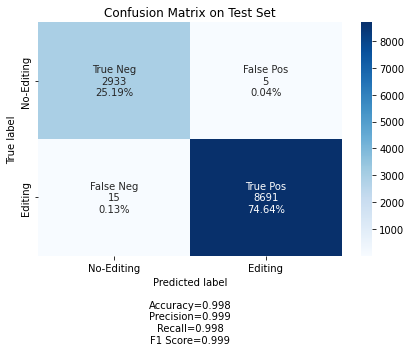

In [58]:
###--- Evaluate on Test set ---###
y_test_hat = model.predict(X_test)
print("\nX_test predicted classes count:", np.unique([np.argmax(i) for i in y_test_hat], return_counts=True))
print("\nAccuracy on test set is:", accuracy_score([np.argmax(i) for i in y_test_le], [np.argmax(i) for i in y_test_hat] ), flush=True)
print("\nConfusion Matrix on test set:\n", confusion_matrix([np.argmax(i) for i in y_test_le], [np.argmax(i) for i in y_test_hat] ), flush=True)
print("\nClassification Report on test set:\n", classification_report([np.argmax(i) for i in y_test_le], [np.argmax(i) for i in y_test_hat], zero_division=1), flush=True)

make_confusion_matrix(confusion_matrix([np.argmax(i) for i in y_test_le], [np.argmax(i) for i in y_test_hat]), 
                      group_names=labels,
                      categories=categories,
                      title = "Confusion Matrix on Test Set",
                      figsize=(6,5),
                      path=os.path.join(model_path, f"{model_name}_Conf_Matrix_TEST.tiff"))